# Machine Learning Pipeline - Should this be a challenge?

**[Big Data and Cloud Computing]**

## Group D
* Daniela Tomás, up202004946
* Diogo Nunes, up202007895
* Diogo Almeida, up202006059

## References
* https://stackoverflow.com/questions/59659344/how-to-process-faster-on-gz-files-in-spark-scala
* https://stackoverflow.com/questions/61961123/my-bar-plot-is-not-showing-bars-for-all-the-data-values

## Data Understanding and Preparation

Firstly, we import the necessary libraries, packages and methods.

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import os

Spark requires the JAVA_HOME environment variable to be set

In [3]:
#os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-17-openjdk-amd64'
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-21-openjdk-21.0.3.0.9-1.fc40.x86_64/'
os.environ['SPARK_LOCAL_IP'] = '127.0.0.1'
os.environ['SPARK_MASTER_HOST'] = 'localhost'

In [4]:
spark = SparkSession.builder \
    .appName("ICU_Length_of_Stay_Prediction") \
    .master("local[*]") \
    .config("spark.driver.host","127.0.0.1") \
    .config("spark.driver.bindAddress","127.0.0.1") \
    .getOrCreate()
sc = spark.sparkContext


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/11 16:13:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Since the dataset is too large (4.2 Gigabytes compressed), we load it into Spark. However, it is inefficient to process gzip-compressed CSV files directly with Spark due to their non-splittable nature, and using an unziped CSV file is not always splittable. As shown in the code below, the CSV file took over 7 minutes to run, which is a considerable time.

```spark.read.csv``` evaluates lazily, which means that the read only occurs when an action is called.

In [4]:
file_path = "dataset/CHARTEVENTS.csv"

df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("delimiter", ",") \
    .load(file_path)

df.printSchema()
df.show(5)

24/05/11 15:48:21 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


root
 |-- ROW_ID: integer (nullable = true)
 |-- SUBJECT_ID: integer (nullable = true)
 |-- HADM_ID: integer (nullable = true)
 |-- ICUSTAY_ID: integer (nullable = true)
 |-- ITEMID: integer (nullable = true)
 |-- CHARTTIME: timestamp (nullable = true)
 |-- STORETIME: timestamp (nullable = true)
 |-- CGID: integer (nullable = true)
 |-- VALUE: string (nullable = true)
 |-- VALUENUM: double (nullable = true)
 |-- VALUEUOM: string (nullable = true)
 |-- WARNING: integer (nullable = true)
 |-- ERROR: integer (nullable = true)
 |-- RESULTSTATUS: string (nullable = true)
 |-- STOPPED: string (nullable = true)

+------+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|
+------+----------+-------+----------+------+-------------------+-------------------+

To improve performance, we load the dataset into Spark using the Parquet file format with Snappy compression, ensuring splittable and efficient parallel processing across multiple nodes in the cluster.

In [5]:
parquet_file_path = "dataset/CHARTEVENTS.parquet"

df.write.format("parquet") \
    .option("compression", "snappy") \
    .save(parquet_file_path)

#spark.stop()

24/05/11 15:49:48 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/05/11 15:49:48 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
24/05/11 15:49:48 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
24/05/11 15:49:48 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
24/05/11 15:49:48 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 63.33% for 12 writers
24/05/11 15:49:56 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
24/05/11 15:49:56 WARN MemoryManager: Total allocation exceeds 95.

Now it's instant!?  
Actually for this format, the data is read lazily and so is only read when required.  
Parquet is columnar storage, which means it organizes data by columns rather than by rows, and this difference affects how data is displayed.

In [5]:
file_path = "dataset/CHARTEVENTS.parquet"

df = spark.read.format("parquet") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(file_path)

df.printSchema()
df.show(5)

root
 |-- ROW_ID: integer (nullable = true)
 |-- SUBJECT_ID: integer (nullable = true)
 |-- HADM_ID: integer (nullable = true)
 |-- ICUSTAY_ID: integer (nullable = true)
 |-- ITEMID: integer (nullable = true)
 |-- CHARTTIME: timestamp (nullable = true)
 |-- STORETIME: timestamp (nullable = true)
 |-- CGID: integer (nullable = true)
 |-- VALUE: string (nullable = true)
 |-- VALUENUM: double (nullable = true)
 |-- VALUEUOM: string (nullable = true)
 |-- WARNING: integer (nullable = true)
 |-- ERROR: integer (nullable = true)
 |-- RESULTSTATUS: string (nullable = true)
 |-- STOPPED: string (nullable = true)

+-------+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
| ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|
+-------+----------+-------+----------+------+-------------------+-----------------

24/05/11 16:13:53 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [6]:
print(f'{df.count()} rows and {len(df.columns)} cols')

330712483 rows and 15 cols


In [7]:
df.describe("VALUENUM").show()

+-------+------------------+
|summary|          VALUENUM|
+-------+------------------+
|  count|         146504168|
|   mean| 71.82548549626641|
| stddev|2047.6643228137305|
|    min|          -10069.0|
|    max|         9999999.0|
+-------+------------------+



In [8]:
events_count_df = df.groupBy("SUBJECT_ID").agg(count("*").alias("total_events"))
events_count_df.describe("total_events").show()

+-------+------------------+
|summary|      total_events|
+-------+------------------+
|  count|             46467|
|   mean| 7117.147287322186|
| stddev|14779.275677390777|
|    min|                 3|
|    max|            775024|
+-------+------------------+



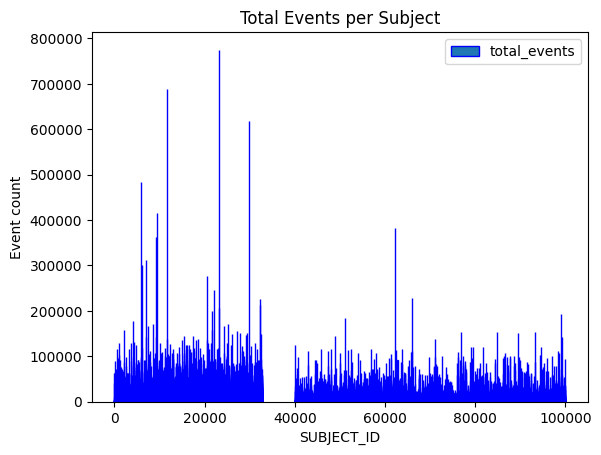

In [9]:
y = [val.total_events for val in events_count_df.select('total_events').collect()]
x = [val.SUBJECT_ID for val in events_count_df.select('SUBJECT_ID').collect()]

plt.bar(x, y, ec='blue')
plt.ylabel('Event count')
plt.xlabel('SUBJECT_ID')
plt.title('Total Events per Subject')
plt.legend(['total_events'], loc='upper right')
plt.show()

### Distribution of ICU Stay Lengths (LOS)

To explore the distribution of ICU stay lengths (LOS), we first group the data by ``SUBJECT_ID``,``HADM_ID`` and ``ICUSTAY_ID`` and calculate the ``admission_time`` and ```discharge_time``` for each patient. Then, we calculate the LOS in hours and describe its statistics.

In [10]:
los_df = df.groupBy("SUBJECT_ID","HADM_ID","ICUSTAY_ID") \
    .agg(
        min("CHARTTIME").alias("admission_time"),
        max("CHARTTIME").alias("discharge_time")
    ) \
    .withColumn("LOS_hours", ((unix_timestamp("discharge_time") - unix_timestamp("admission_time")) / 3600).cast("int"))

los_df.show(5)

+----------+-------+----------+-------------------+-------------------+---------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|     admission_time|     discharge_time|LOS_hours|
+----------+-------+----------+-------------------+-------------------+---------+
|     24586| 145340|    265334|2152-09-23 04:43:00|2152-09-26 13:38:00|       80|
|     25935| 188026|    244601|2121-03-16 01:47:00|2121-03-17 21:15:00|       43|
|     25876| 131372|    209266|2191-02-24 08:51:00|2191-02-25 06:52:00|       22|
|     27500| 141187|    210911|2173-10-08 01:00:00|2173-10-09 16:53:00|       39|
|     27790| 127130|    249511|2113-07-12 17:37:00|2113-07-14 00:11:00|       30|
+----------+-------+----------+-------------------+-------------------+---------+
only showing top 5 rows



We observed that:
* There are 62654 observations available for analysis
* The average LOS is approximately 113 hous ~ 4.7 days
* The standard deviation suggests that the LOS are widely spread out from the average
* The minimum LOS is 0 hours
* The maximum LOS is 17519 hours ~ 2 years

In [11]:
los_df.describe("LOS_hours").show()

+-------+------------------+
|summary|         LOS_hours|
+-------+------------------+
|  count|             62654|
|   mean|113.53680531171194|
| stddev|238.81173467985093|
|    min|                 0|
|    max|             17519|
+-------+------------------+



To determine if there is subjects with more than one hospital admission, we do a groupBy operation on the ``SUBJECT_ID`` column and then count the number of unique ``HADM_IDs`` for each ``SUBJECT_ID``. 

We discovered that 6515 patients had more than one hospital admission.

In [12]:
subjects_multiple_admissions = los_df.groupBy("SUBJECT_ID").agg(countDistinct("HADM_ID").alias("num_admissions")).filter(col("num_admissions") > 1)
subjects_multiple_admissions.describe("num_admissions").show()

+-------+------------------+
|summary|    num_admissions|
+-------+------------------+
|  count|              6515|
|   mean|2.6584804297774367|
| stddev|  1.65810959886756|
|    min|                 2|
|    max|                41|
+-------+------------------+



To determine if there is subjects with more than one ICU stay, we do a groupBy operation on the ``SUBJECT_ID`` column and then count the number of unique ``ICUSTAY_IDs`` for each ``SUBJECT_ID``. 

We discovered that 8436 patients had more than one ICU stay.

In [13]:
subjects_multiple_icu_stays = los_df.groupBy("SUBJECT_ID").agg(countDistinct("ICUSTAY_ID").alias("num_icu_stays")).filter(col("num_icu_stays") > 1)
subjects_multiple_icu_stays.describe("num_icu_stays").show()

+-------+------------------+
|summary|     num_icu_stays|
+-------+------------------+
|  count|              8436|
|   mean|2.7072072072072073|
| stddev|1.6789361311614799|
|    min|                 2|
|    max|                41|
+-------+------------------+



### Missing Values

In [14]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----------+-------+----------+------+---------+---------+-------+-------+---------+---------+---------+---------+------------+---------+
|ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|CHARTTIME|STORETIME|   CGID|  VALUE| VALUENUM| VALUEUOM|  WARNING|    ERROR|RESULTSTATUS|  STOPPED|
+------+----------+-------+----------+------+---------+---------+-------+-------+---------+---------+---------+---------+------------+---------+
|     0|         0|      0|    297529|     0|        0|  6312672|6312672|2071349|184208315|213982888|221315841|221315841|   321182823|110282285|
+------+----------+-------+----------+------+---------+---------+-------+-------+---------+---------+---------+---------+------------+---------+



In [15]:
icu_null_df = los_df.filter(col("ICUSTAY_ID").isNull())
print(f"The column ICUSTAY_ID has {icu_null_df.count()} null values.")

The column ICUSTAY_ID has 1661 null values.


In [16]:
icu_null_df.describe("LOS_hours").show()

+-------+-----------------+
|summary|        LOS_hours|
+-------+-----------------+
|  count|             1661|
|   mean|34.82781456953642|
| stddev|524.6768510665974|
|    min|                0|
|    max|            17519|
+-------+-----------------+



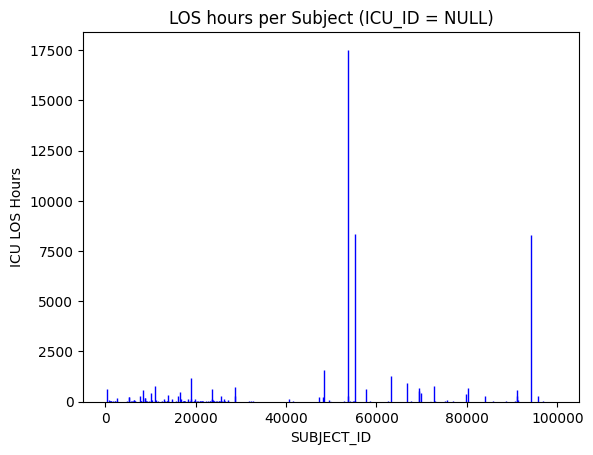

In [17]:
y = [val.LOS_hours for val in icu_null_df.select('LOS_hours').collect()]
x = [val.SUBJECT_ID for val in icu_null_df.select('SUBJECT_ID').collect()]

plt.bar(x, y, ec='blue')
plt.ylabel('ICU LOS Hours')
plt.xlabel('SUBJECT_ID')
plt.title('LOS hours per Subject (ICU_ID = NULL)')
plt.show()

Let's take a look at the LOS equal to 17519. In this case, as the time is very similar, there was probably an error when entering the date.

In [18]:
los_17519_subjects = icu_null_df.filter(col("LOS_hours") == 17519)
los_17519_subjects.show()

+----------+-------+----------+-------------------+-------------------+---------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|     admission_time|     discharge_time|LOS_hours|
+----------+-------+----------+-------------------+-------------------+---------+
|     53743| 136583|      NULL|2175-12-26 20:23:00|2177-12-25 20:00:00|    17519|
+----------+-------+----------+-------------------+-------------------+---------+



Therefore, this outlier has been removed.

Now we can observe that:
* There are 1660 ICU stays null
* The average LOS is approximately 24 hous ~ 1 days
* The standard deviation suggests that the LOS are widely spread out from the average
* The minimum LOS is 0 hours
* The maximum LOS is 8360 hours ~ 11 months

In [19]:
icu_null_df = icu_null_df.filter(col("LOS_hours") != 17519)
icu_null_df.describe("LOS_hours").show()

+-------+------------------+
|summary|         LOS_hours|
+-------+------------------+
|  count|              1660|
|   mean|24.295180722891565|
| stddev|301.78691587408855|
|    min|                 0|
|    max|              8360|
+-------+------------------+



Let's take a look at the other two LOS outliers (> 8000). These values seem to be as expected for an ICU LOS.

In [20]:
los_8360_subjects = icu_null_df.filter(col("LOS_hours") > 8000)
los_8360_subjects.show()

+----------+-------+----------+-------------------+-------------------+---------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|     admission_time|     discharge_time|LOS_hours|
+----------+-------+----------+-------------------+-------------------+---------+
|     55308| 131281|      NULL|2129-06-13 00:00:00|2130-05-27 08:40:00|     8360|
|     94119| 110915|      NULL|2112-09-08 03:05:00|2113-08-19 20:00:00|     8296|
+----------+-------+----------+-------------------+-------------------+---------+



Some of the subjects with an LOS of 0 have the same ``admission_time`` and ``discharge_time``, which is impossible and probably indicates an error. Once again, we decided to remove these rows.

In [21]:
icu_null_df.filter(col("admission_time") == col("discharge_time")).describe("LOS_hours").show()

+-------+---------+
|summary|LOS_hours|
+-------+---------+
|  count|     1180|
|   mean|      0.0|
| stddev|      0.0|
|    min|        0|
|    max|        0|
+-------+---------+



In [22]:
icu_null_df = icu_null_df.filter(col("admission_time") != col("discharge_time"))

Now we can observe that:
* There are 480 ICU stays null
* The average LOS is approximately 84 hous ~ 3.5 days
* The standard deviation suggests that the LOS are widely spread out from the average
* The minimum LOS is 0 hours
* The maximum LOS is 8360 hours ~ 11 months

In [23]:
icu_null_df.describe("LOS_hours").show()

+-------+-----------------+
|summary|        LOS_hours|
+-------+-----------------+
|  count|              480|
|   mean|84.02083333333333|
| stddev|557.1423842325058|
|    min|                0|
|    max|             8360|
+-------+-----------------+



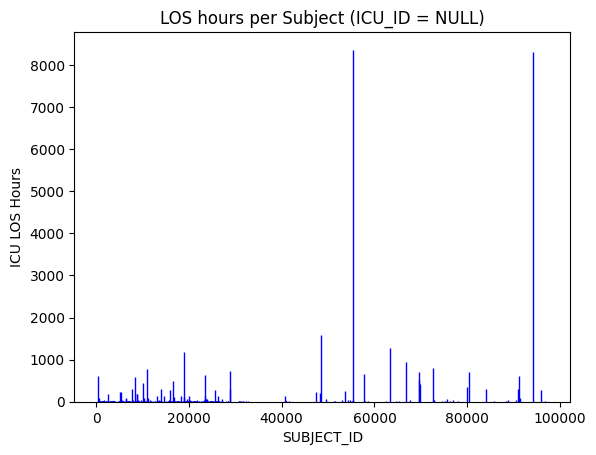

In [24]:
y = [val.LOS_hours for val in icu_null_df.select('LOS_hours').collect()]
x = [val.SUBJECT_ID for val in icu_null_df.select('SUBJECT_ID').collect()]

plt.bar(x, y, ec='blue')
plt.ylabel('ICU LOS Hours')
plt.xlabel('SUBJECT_ID')
plt.title('LOS hours per Subject (ICU_ID = NULL)')
plt.show()

In [ ]:
#TODO enter ICU_ID values

### Duplicate Values

There are no duplicates in the dataset.

In [ ]:
#duplicate_rows_count = df.count() - df.distinct().count()

df.groupBy(df.columns)\
    .count()\
    .where(col('count') > 1)\
    .select(sum('count'))\
    .show()

#+----------+
#|sum(count)|
#+----------+
#|      NULL|
#+----------+

In [25]:
los_df.groupBy(los_df.columns)\
    .count()\
    .where(col('count') > 1)\
    .select(sum('count'))\
    .show()

+----------+
|sum(count)|
+----------+
|      NULL|
+----------+



In [9]:
spark.stop()